In [1]:
# import SimPEG.dask as simpeg
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
from SimPEG.electromagnetics import natural_source as ns
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver


In [2]:
# let import the mesh of the UBC example
mesh_file = "./input_files/octree_mesh.txt"
mesh = discretize.TreeMesh.readUBC(mesh_file)

# the forward model
# fwd_file = 
# discretize.TreeMesh.readModelUBC(mesh, actind_file)

# active blocks
actind_file = "./input_files/active_cells_topo.txt"
actinds = discretize.TreeMesh.readModelUBC(mesh, actind_file)
actinds = actinds.astype(bool)
np.save('octree_active_cells.npy', actinds)

/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize-0.8.1-py3.9-linux-x86_64.egg/discretize/mixins/mesh_io.py:594: FutureWarning: TensorMesh.readUBC has been deprecated and will be removed indiscretize 1.0.0. please use TensorMesh.read_UBC
  warnings.warn(
/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize-0.8.1-py3.9-linux-x86_64.egg/discretize/utils/code_utils.py:217: FutureWarning: TreeMesh.readModelUBC has been deprecated, please use TreeMesh.read_model_UBC. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


(50724,) 50724


/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize-0.8.1-py3.9-linux-x86_64.egg/discretize/utils/code_utils.py:182: FutureWarning: TreeMesh.vol has been deprecated, please use TreeMesh.cell_volumes. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


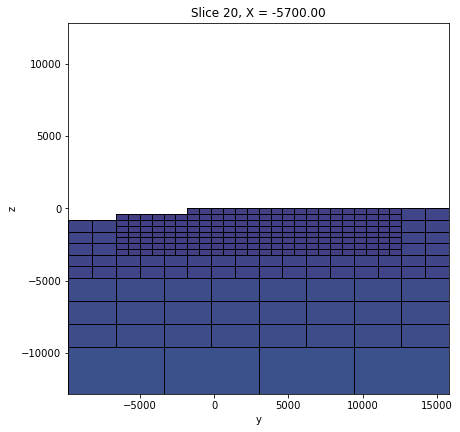

In [3]:
print(actinds.shape, mesh.nC)
# plot the mesh
model = np.ones(mesh.nC)
model[~actinds] = np.nan
model[actinds] = np.log(mesh.vol[actinds])
ind_slice = int(10)
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(2, 2, 1)
# mesh.plot_slice(model, normal="Z", ax=ax, ind=ind_slice, grid=True, clim=[model[actinds].min(), model[actinds].max()])
collect_obj1 = mesh.plot_slice(model, ax=ax, ind=int(20), grid=True, normal='X', clim=[1, 100])

(169, 3)


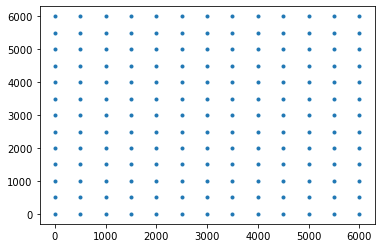

In [4]:
# create receivers
rx_x, rx_y = np.meshgrid(np.arange(0, 6500, 500), np.arange(0, 6500, 500))
rx_loc = np.hstack((mkvc(rx_x, 2), mkvc(rx_y, 2), np.zeros((np.prod(rx_x.shape), 1))))
print(rx_loc.shape)

plt.plot(rx_loc[:, 0], rx_loc[:, 1], '.')
plt.show()


(50724,)


/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize-0.8.1-py3.9-linux-x86_64.egg/discretize/utils/code_utils.py:217: FutureWarning: TreeMesh.plotSlice has been deprecated, please use TreeMesh.plot_slice. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


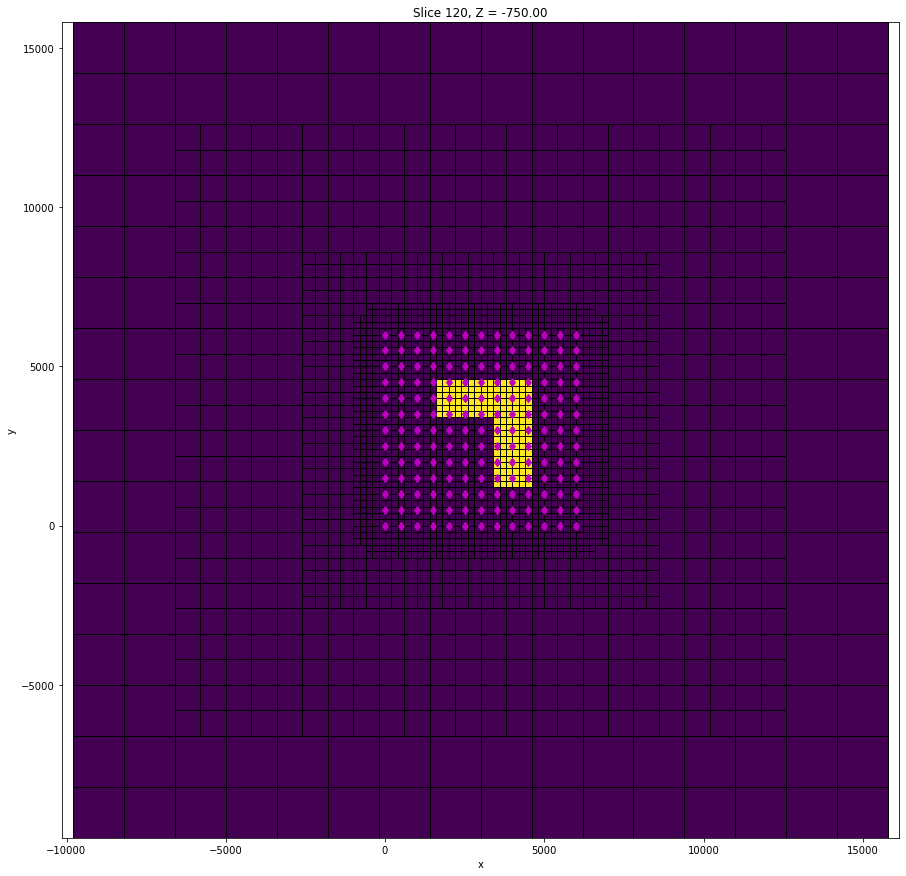

In [5]:
# # create Mesh
# mesh = discretize.TensorMesh(
# [
#     [(100, 5, -2), (200., 40), (100, 5, 2)],
#     [(100, 5, -2), (200., 40), (100, 5, 2)],
#     [(100, 7, -1.6), (100., 20), (100, 3, 2)]
# ])
# mesh.x0 = [-np.sum(mesh.hx[:10]), -np.sum(mesh.hy[:10]), -np.sum(mesh.hy[:18] - 5)]

# ===================================================================================================================
# for when Octree-tree is usuable

# print(meshInput.x0)

# padLen = 800
# octreeObs = [17, 5, 5]
# octreeTopo = [5, 2, 1]
# h = [meshInput.hx.min(), meshInput.hy.min(), meshInput.hy.min()]
# # h = [25, 25, 25]
# print(h)
# padDist = np.r_[np.c_[padLen, padLen], np.c_[padLen, padLen], np.c_[padLen, 0]]
# # padDist = np.ones((3,2)) * 400.
# # padDist[2, 0] = 0
# # padDist[2, 1] = 0
# print(padDist)
# mesh = meshBuilder(rx_loc, h, padDist,
#                    meshType='TREE', meshGlobal=meshInput,
#                    verticalAlignment='top')
# # Refine the mesh around topographyttb
# # mesh = refineTree(mesh, rx_loc, dtype='surface',
# #                   nCpad=[0, 0, 1, 1], finalize=False)

# # Refine the mesh around topographyttb
# mesh = refineTree(mesh, rx_loc, dtype='surface',
#                   nCpad=[15, 10, 5], finalize=True)
# ====================================================================================================================

## create target blocks
block_1 = utils.model_builder.getIndicesBlock([1600, 4600, -1200], [4600, 3400, -400], mesh.gridCC)[0].tolist() # Porphyry Intrusion
block_2 = utils.model_builder.getIndicesBlock([3400, 4600, -1200], [4600, 1200, -400], mesh.gridCC)[0].tolist() # Porphyry Intrusion
# print(block_1)
background = 100  # ohm-m
target = 1        # ohm-m

## set elvation to a hieght
active = mesh.gridCC[:, 2] < 1
sig = np.ones(mesh.nC) * 1 / background

## assign conductivities of target
sig[block_1] = 1 / target
sig[block_2] = 1 / target
sig[~active] = 1e-8
model_true = np.log(sig)
model_true[~actinds] = 1e-8

# create background conductivity model
sigBG = np.zeros(mesh.nC) + 1 / background
sigBG[~active] = 1e-8

print(model_true.shape)

rx_loc[:, 2] = 0

# Make a receiver list
rx_list = []
for rx_orientation in ['xx', 'xy', 'yx', 'yy']:
    
    rx_list.append(
        
        ns.receivers.PointNaturalSource(
            rx_loc, orientation=rx_orientation, component="real"
        )
    )
    rx_list.append(
        ns.receivers.PointNaturalSource(
            rx_loc, orientation=rx_orientation, component="imag"
        )
    )

# Source list
src_list = [ns.sources.Planewave_xy_1Dprimary(rx_list, frequency=f) for f in [10, 50, 200]]

# Survey MT
survey = ns.Survey(src_list)
survey.m_true = model_true

# survey.drape_topography(mesh, actinds, option='top')                       # drape topo

# plot the mesh
model = sig
model[~active] = np.nan
ind_slice = int(120)
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
mesh.plotSlice(model, normal="Z", ax=ax, ind=ind_slice, grid=True)
# rx_loc[:, 2] = 0
ax.axis("equal")
plt.plot(rx_loc[:, 0], rx_loc[:, 1], 'dm')
# plt.show()
# plt.hist(sig)
# plt.show()

In [15]:

# Set the mapping
actMap = maps.InjectActiveCells(
    mesh=mesh, indActive=active, valInactive=np.log(1e-8)
)
mapping = maps.ExpMap(mesh) * actMap

# Setup the problem object
sim = ns.simulation.Simulation3DPrimarySecondary(
    
    mesh,
    survey=survey,
    sigmaMap=mapping,
    sigmaPrimary=sigBG,
    solver=Solver

)

sim.model = sigBG[active]

sim.survey.dtrue = sim.dpred(model_true[active])
# create observations
sim.survey.dobs = sim.survey.dtrue


/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize-0.8.1-py3.9-linux-x86_64.egg/discretize/utils/code_utils.py:182: FutureWarning: TreeMesh.edgeCurl has been deprecated, please use TreeMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize-0.8.1-py3.9-linux-x86_64.egg/discretize/utils/code_utils.py:217: FutureWarning: TreeMesh.getEdgeInnerProduct has been deprecated, please use TreeMesh.get_edge_inner_product. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize-0.8.1-py3.9-linux-x86_64.egg/discretize/utils/code_utils.py:217: FutureWarning: TreeMesh.getInterpolationMat has been deprecated, please use TreeMesh.get_interpolation_matrix. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


169


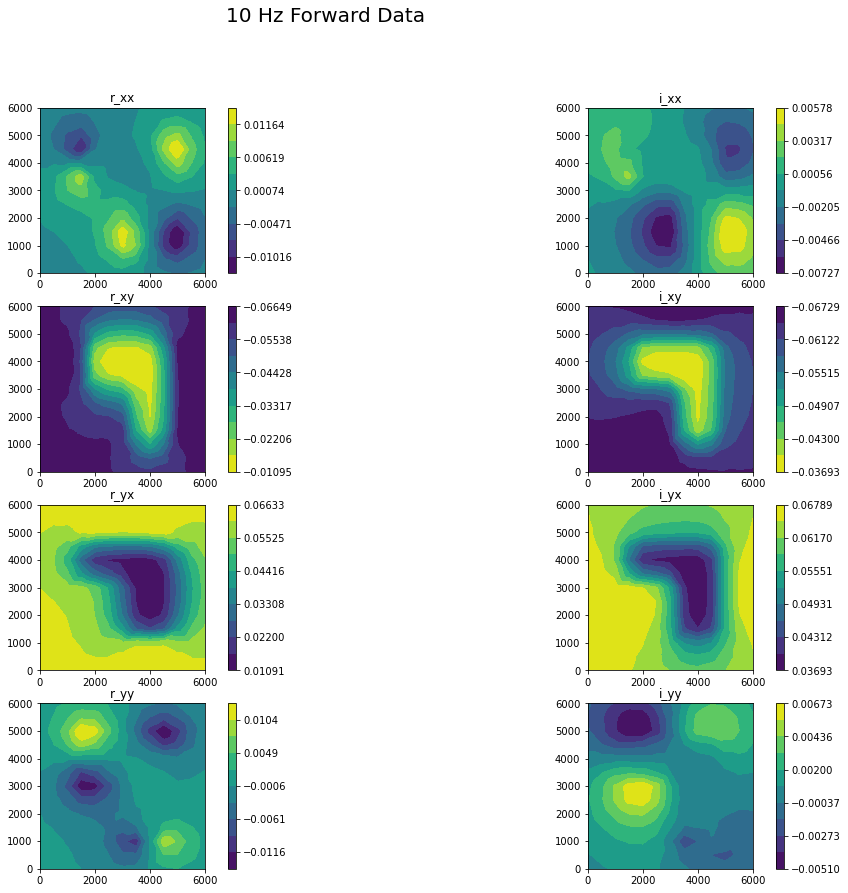

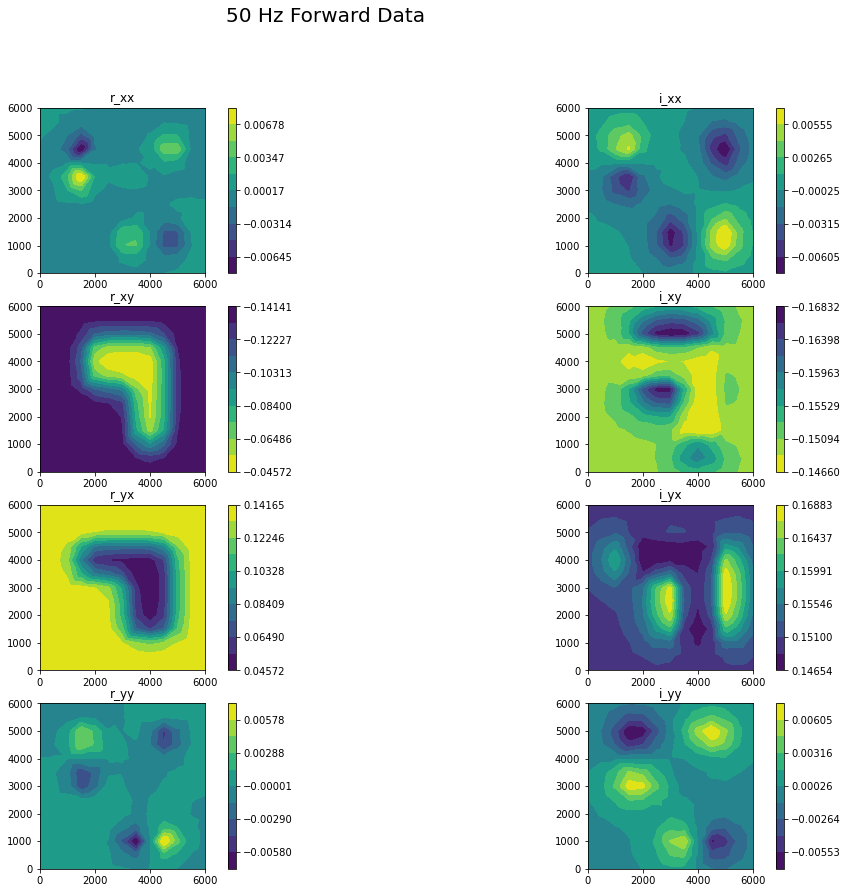

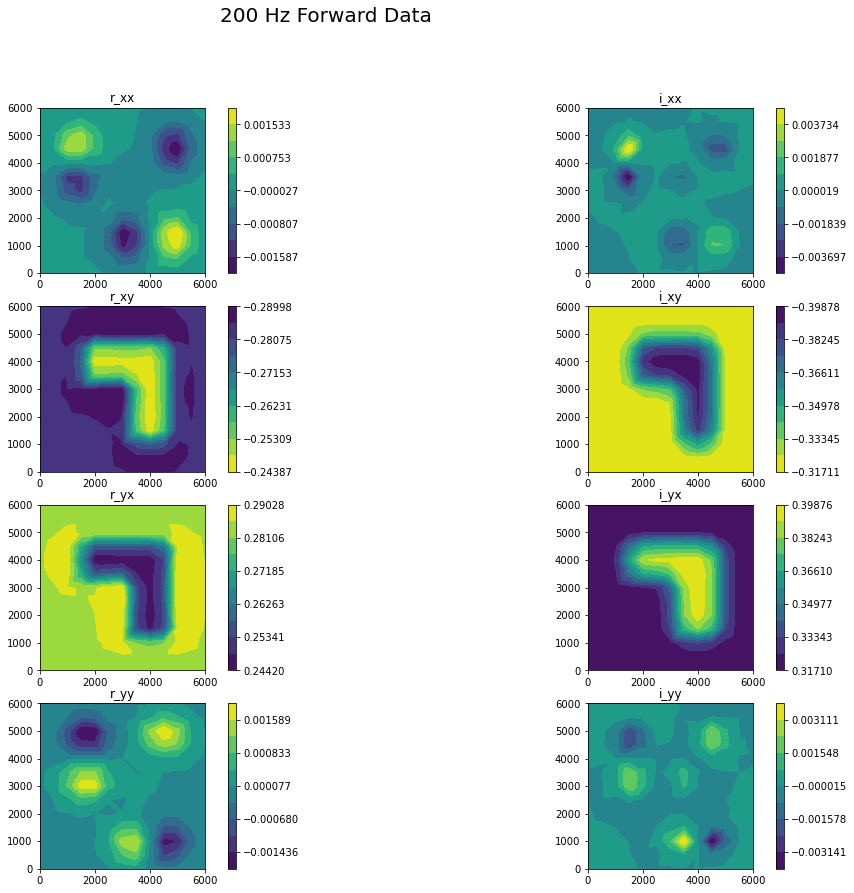

[0.00100812 0.00100243 0.0010002 ] (4056,)


In [67]:
# Assign uncertainties
std = 0.05  # 5% std
sim.survey.std = np.abs(survey.dobs) * std
# make data object
fwd_data = data.Data(sim.survey)

# reshape data for plotting
print(rx_loc.shape[0])
num_station = rx_loc.shape[0]
freqs = ['10', '50', '200']
num_sets = int(survey.dobs.shape[0] / len(freqs))
dnew = np.reshape(survey.dobs, (3, num_sets))
stdnew = np.reshape(survey.std, (3, num_sets))

cnt = 0

for freq in freqs:
    cnt_comp = 0
#     comps_ = ['rho_xy', 'phi_xy', 'rho_yx', 'phi_yx']
    comps_ = ['r_xx', 'i_xx', 'r_xy', 'i_xy', 'r_yx', 'i_yx', 'r_yy', 'i_yy']
    fig1 = plt.figure(figsize=(18, 14))
    for rx_orientation in range(len(comps_)):
        pert = 1e-3
        pert_diag = 1e-2  #np.percentile(np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]), 10)
        if comps_[rx_orientation][-2:] == 'xx':
            stdnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] = np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] * 0.1) + pert
        elif comps_[rx_orientation][-2:] == 'yy':
            stdnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] = np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] * 0.1) + pert
        else:
#             print(pert_diag)
            stdnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] = np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] * 0.05) + pert_diag
            
        ax = plt.subplot(4,2, cnt_comp + 1)
        im = utils.plot_utils.plot2Ddata(rx_loc, dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)], ax=ax)
        ax.set_title(comps_[rx_orientation])
        plt.colorbar(im[0])
        cnt_comp += 1
    cnt += 1
    fig1.suptitle(freq + ' Hz Forward Data', fontsize='20')
plt.show()
print(mkvc(stdnew)[:3], stdnew.flatten('F').shape)

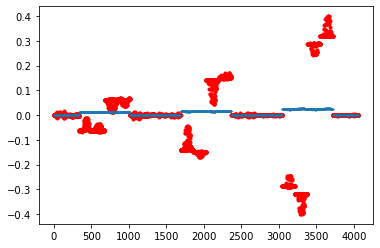

In [68]:
# np.save('Lb-imp_all-obs.npy', survey.dobs)
# np.save('Lb-imp-all-dpred_pre.npy', invProb.dpred)
# plt.plot(mkvc(stdnew), '.r')
# plt.plot(survey.std, '.', ms=1)
# plt.show()

## Fill the data object
fwd_data.dobs = sim.survey.dobs
fwd_data.standard_deviation = stdnew.flatten()  # sim.survey.std
sim.survey.std = stdnew.flatten()
survey.std = stdnew.flatten()

plt.plot(survey.dobs, '.r')
plt.plot(survey.std, '.', ms=1)
plt.show()

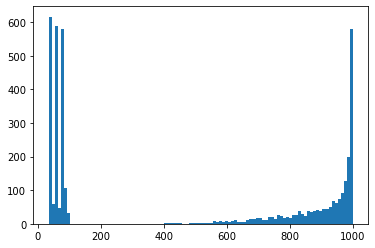

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***


/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize-0.8.1-py3.9-linux-x86_64.egg/discretize/utils/code_utils.py:182: FutureWarning: TreeMesh._cellGradxStencil has been deprecated, please use TreeMesh.stencil_cell_gradient_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize-0.8.1-py3.9-linux-x86_64.egg/discretize/utils/code_utils.py:182: FutureWarning: TreeMesh._cellGradyStencil has been deprecated, please use TreeMesh.stencil_cell_gradient_y. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize-0.8.1-py3.9-linux-x86_64.egg/discretize/utils/code_utils.py:182: FutureWarning: TreeMesh._cellGradzStencil has been deprecated, please use TreeMesh.stencil_cell_gradient_z. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/

In [ ]:
Wd = 1 / survey.std
plt.hist(Wd, 100)
plt.show()
# Setup the inversion proceedure
# Define a counter
C = utils.Counter()
# Optimization
opt = optimization.ProjectedGNCG(maxIter=5, upper=np.inf, lower=-np.inf)
opt.counter = C
opt.maxIterCG = 20
# opt.LSshorten = 0.5
opt.remember('xc')
# Data misfit
dmis = data_misfit.L2DataMisfit(data=fwd_data, simulation=sim)
dmis.W = Wd
# Regularization
regmap = maps.IdentityMap(nP=int(active.sum()))
# reg = regularization.Sparse(mesh, indActive=active, mapping=regmap)
reg = regularization.Simple(mesh, indActive=active, mapping=regmap)

reg.alpha_s = 4e-6
reg.alpha_x = 1.
reg.alpha_y = 1.
reg.alpha_z = 1.
# reg.mrefInSmooth = True
# Inversion problem
invProb = inverse_problem.BaseInvProblem(dmis, reg, opt)
invProb.counter = C
# Beta schedule
beta = directives.BetaSchedule()
beta.coolingRate = 1.
beta.coolingFactor = 4.
# Initial estimate of beta
beta_est = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
# Target misfit stop
targmis = directives.TargetMisfit()
# targmis.target = survey.nD
saveIter = directives.SaveModelEveryIteration()
# Create an inversion object
directive_list = [beta, beta_est, targmis, saveIter]
inv = inversion.BaseInversion(invProb, directiveList=directive_list)

# Set the conductivity values
sig_half = 0.01
sig_air = 1e-8
# Make the background model
sigma_0 = np.ones(mesh.nC) * sig_air
sigma_0[active] = sig_half
m_0 = np.log(sigma_0[active])

import time
start = time.time()
# Run the inversion
mopt = inv.run(m_0)
print('Inversion took {0} seconds'.format(time.time() - start))

In [55]:
print(invProb.beta, invProb.phi_d, invProb.phi_m, sim.survey.nD)
# map the conductivity
cond_est = mapping * mopt

discretize.TensorMesh.writeUBC(mesh,'Lb-imp_all_simple-octree-v2.msh', models={'Lb-imp_all_simple-octree-v2.con': cond_est})

1.3180433945059556e-06 1472.8888557035202 59157249.42353277 4056


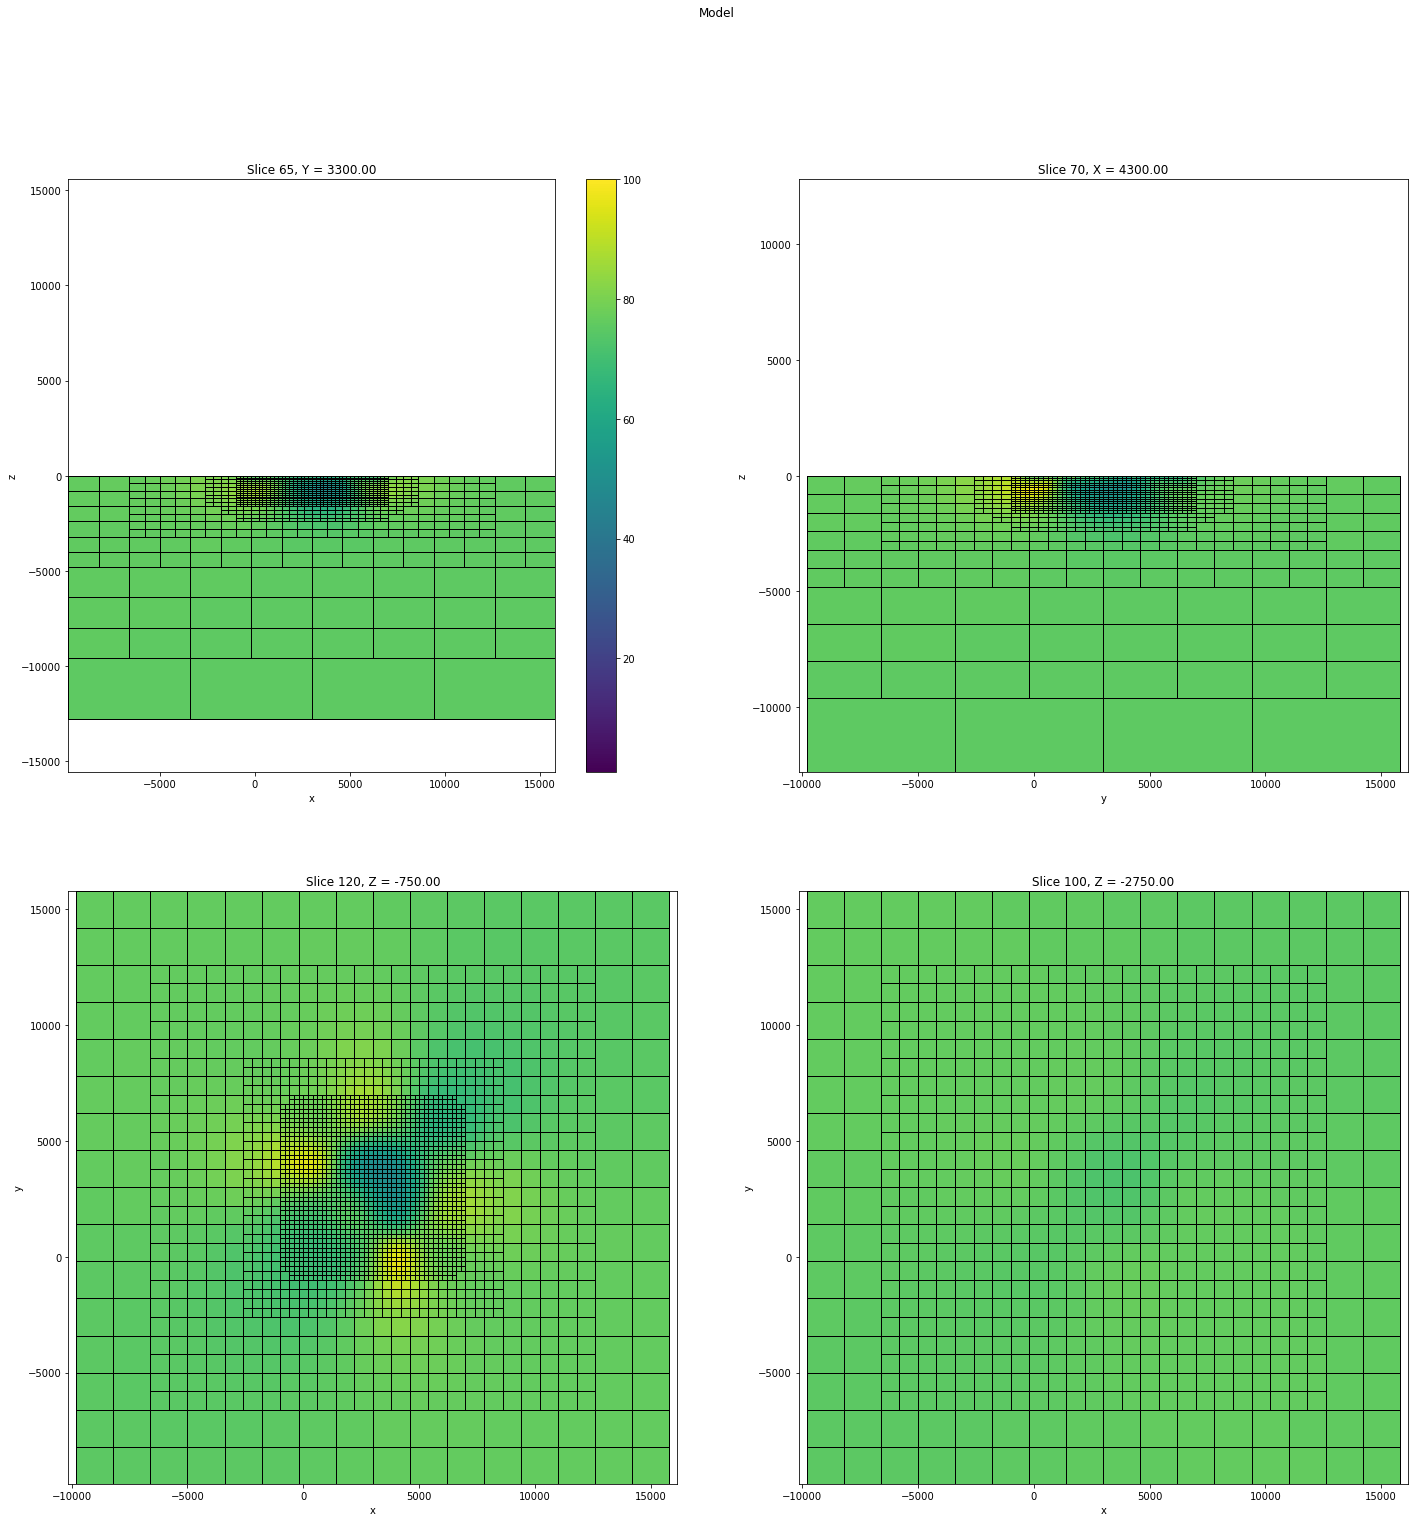

In [56]:
# modeli = np.ones(mesh.nC) 
modeli = 1 / cond_est
modeli[~active] = np.nan
# modeli[active] = cond_est
plt.figure(figsize=(24, 24))
plt.suptitle('Model')
ax = plt.subplot(2, 2, 1)
collect_obj = mesh.plot_slice(modeli, ax=ax, ind=int(65), grid=True, normal='Y', clim=[1, 100])
color_bar = plt.colorbar(collect_obj[0])
ax.axis('equal')
ax1 = plt.subplot(2, 2, 2)
collect_obj1 = mesh.plot_slice(modeli, ax=ax1, ind=int(70), grid=True, normal='X', clim=[1, 100])
# color_bar1 = plt.colorbar()
ax1.axis('equal')
# plt.show()

ax2 = plt.subplot(2, 2, 3)
collect_obj2 = mesh.plot_slice(modeli, ax=ax2, ind=int(120), grid=True, normal='Z', clim=[1, 100])
# color_bar2 = plt.colorbar()
ax2.axis('equal')
# plt.show()

ax3 = plt.subplot(2, 2, 4)
collect_obj3 = mesh.plot_slice(modeli, ax=ax3, ind=int(100), grid=True, normal='Z', clim=[1, 100])
# color_bar3 = plt.colorbar()
# ax3.set_xlim([-5000, 30000])
ax3.axis('equal')
plt.show()

# print(mesh.nCz)

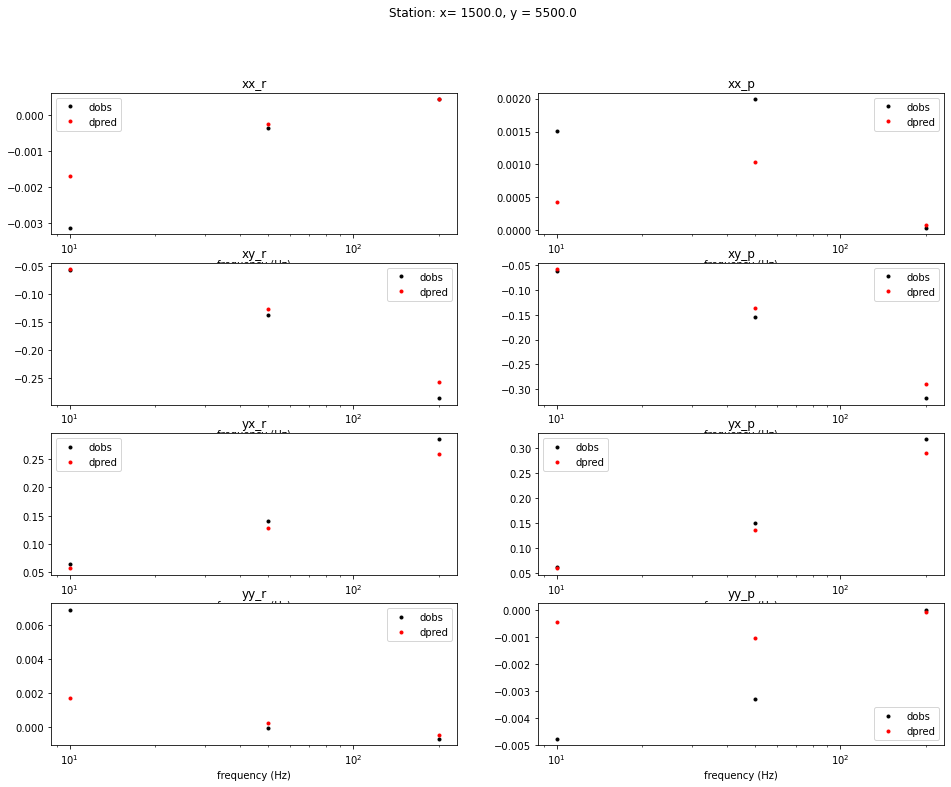

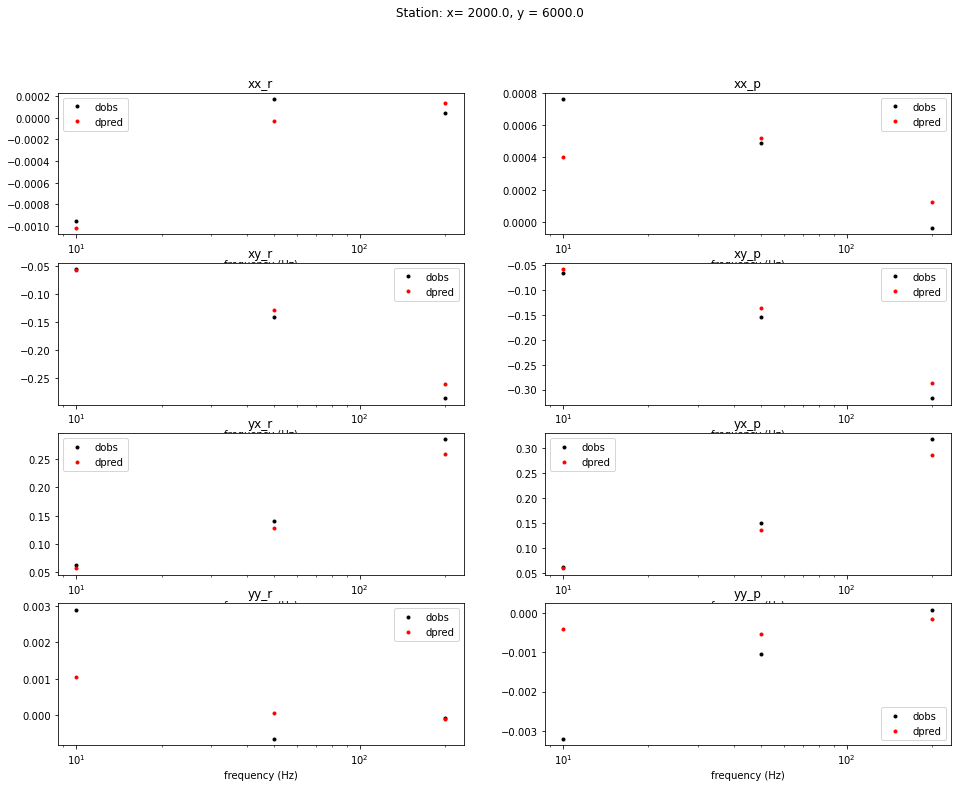

In [57]:
# plot dpred & dobs for specific station - checking fit of each frequency for a station
num_sets = int(survey.dobs.shape[0] / 3.)
dnew = np.reshape(survey.dobs, (3, num_sets))
dpred_new = np.reshape(invProb.dpred, (3, num_sets))
d_wd = dmis.W.diagonal()
Wd_new = np.reshape(d_wd, (3, num_sets))
# set station ID
stn_id = 50
location_id = rx_loc[stn_id, :]
plt.figure(figsize=(16, 12))
plt.suptitle('Station: x= {0}, y = {1}'.format(location_id[0], location_id[1]))
cnt = 0
for rx_orientation in ['xx_r', 'xx_p', 'xy_r', 'xy_p', 'yx_r', 'yx_p', 'yy_r', 'yy_p']:
    ax = plt.subplot(4,2, cnt + 1)
    ax.semilogx(survey.frequencies, dnew[:, stn_id + int(cnt * num_station)], '.k')
    ax.semilogx(survey.frequencies, dpred_new[:, stn_id + int(cnt * num_station)], '.r')
    ax.set_title(rx_orientation)
    ax.legend(['dobs', 'dpred'])
    ax.set_xlabel('frequency (Hz)')
    cnt += 1

plt.show()

# set second station ID
stn_id = 64
location_id = rx_loc[stn_id, :]
plt.figure(figsize=(16, 12))
plt.suptitle('Station: x= {0}, y = {1}'.format(location_id[0], location_id[1]))
cnt = 0
for rx_orientation in ['xx_r', 'xx_p', 'xy_r', 'xy_p', 'yx_r', 'yx_p', 'yy_r', 'yy_p']:
    ax = plt.subplot(4,2, cnt + 1)
    ax.semilogx(survey.frequencies, dnew[:, stn_id + int(cnt * num_station)], '.k')
    ax.semilogx(survey.frequencies, dpred_new[:, stn_id + int(cnt * num_station)], '.r')
    ax.set_title(rx_orientation)
    ax.legend(['dobs', 'dpred'])
    ax.set_xlabel('frequency (Hz)')
    cnt += 1

plt.show()

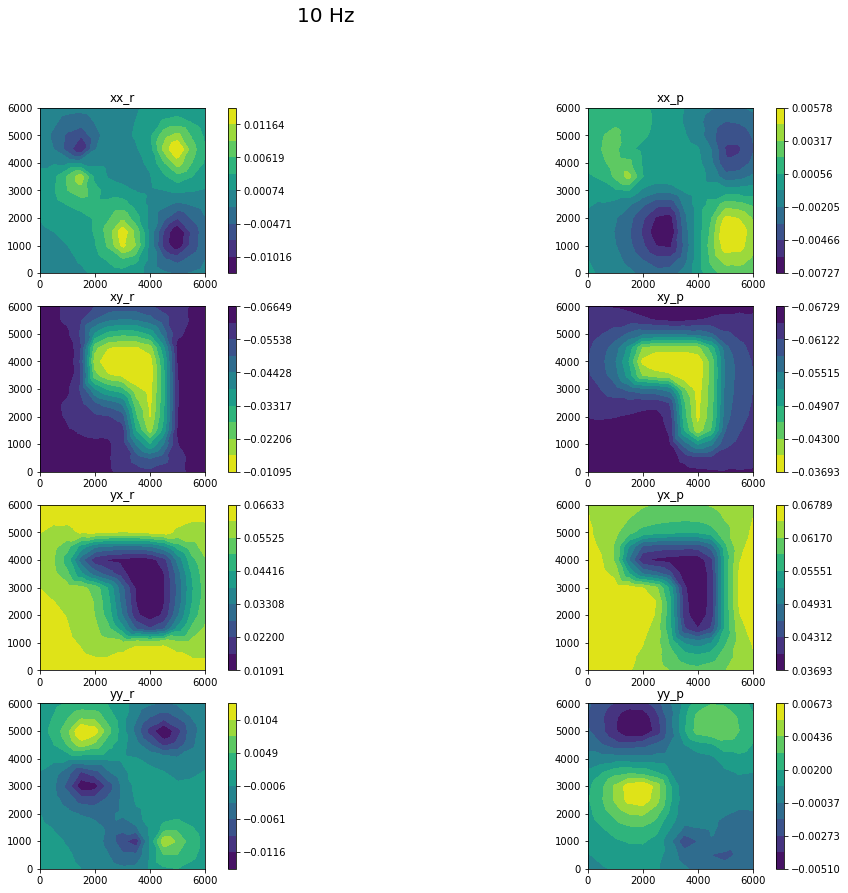

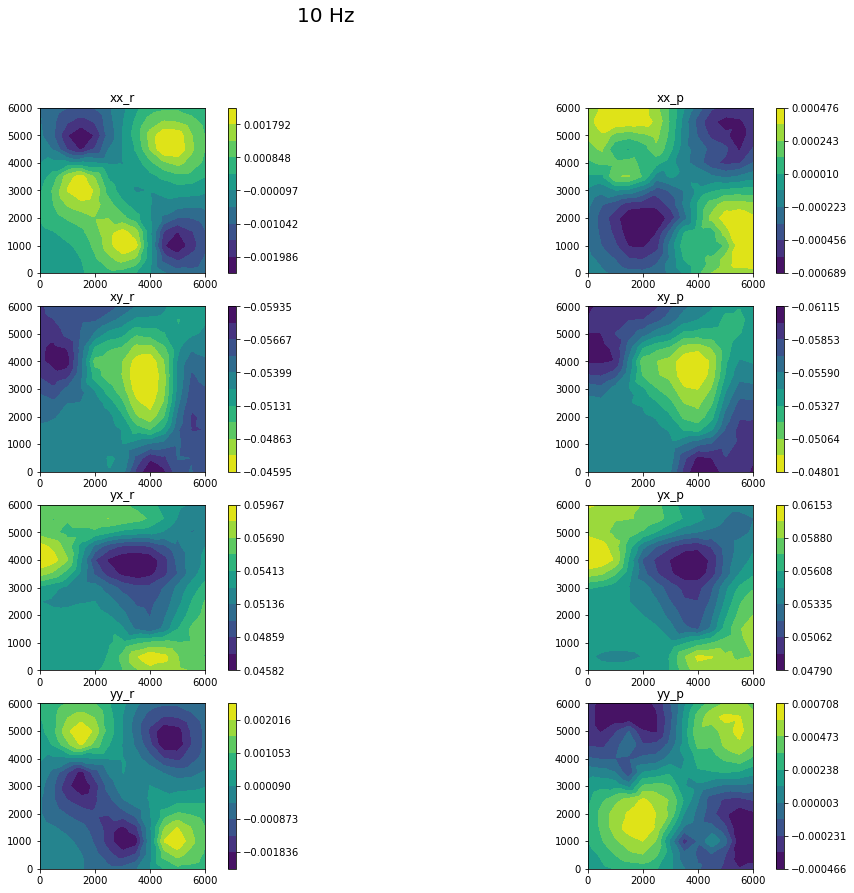

In [58]:
# plotting obs maps
freqs = ['10', '50', '200']
cnt = 0
cnt_comp = 0
comps_ = ['xx_r', 'xx_p', 'xy_r', 'xy_p', 'yx_r', 'yx_p', 'yy_r', 'yy_p']
fig1 = plt.figure(figsize=(18, 14))
for rx_orientation in range(len(comps_)):
    ax = plt.subplot(4,2, cnt_comp + 1)
    im = utils.plot_utils.plot2Ddata(rx_loc, dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)], ax=ax)
    ax.set_title(comps_[rx_orientation])
    plt.colorbar(im[0])
    cnt_comp += 1
fig1.suptitle(freqs[cnt] + ' Hz', fontsize='20')
plt.show()

# plotting dpred maps
fig2 = plt.figure(figsize=(18, 14))
cnt_comp = 0
for rx_orientation in range(len(comps_)):
    ax = plt.subplot(4,2, cnt_comp + 1)
    im = utils.plot_utils.plot2Ddata(rx_loc, dpred_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)], ax=ax)
    ax.set_title(comps_[rx_orientation])
    plt.colorbar(im[0])
    cnt_comp += 1
fig2.suptitle(freqs[cnt] + ' Hz', fontsize='20')
plt.show()

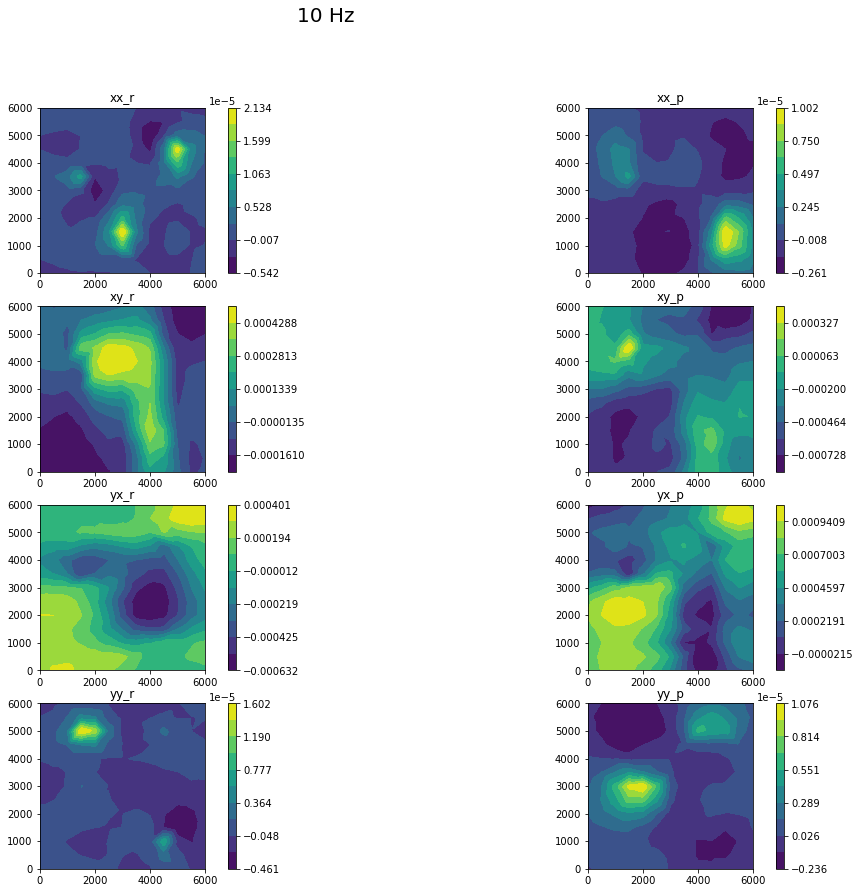

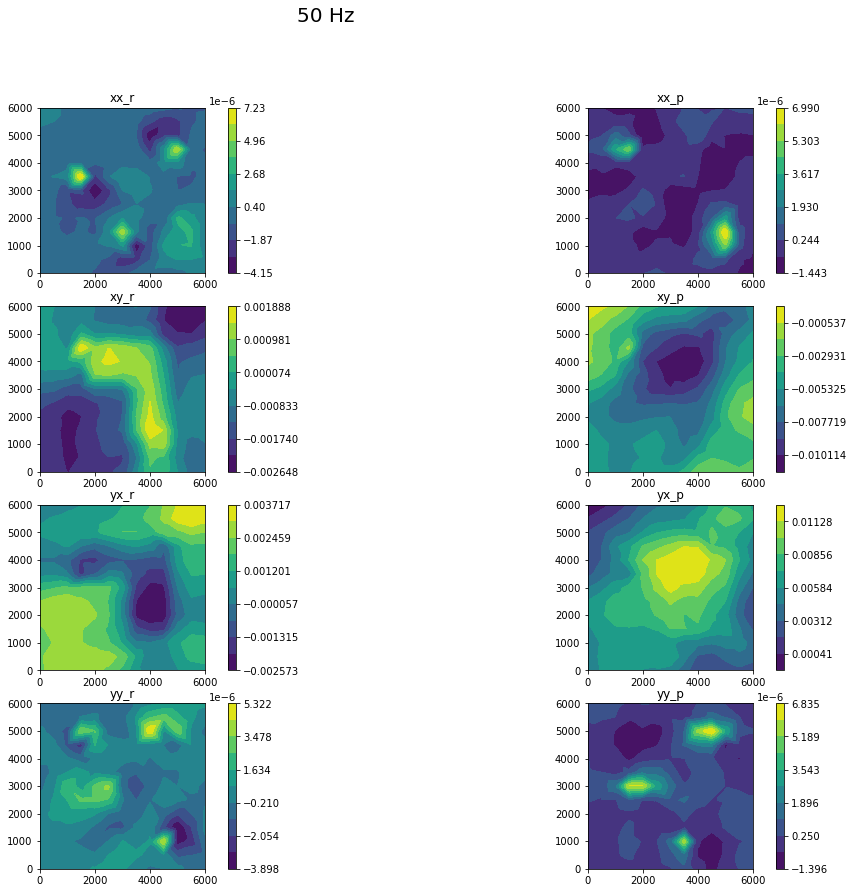

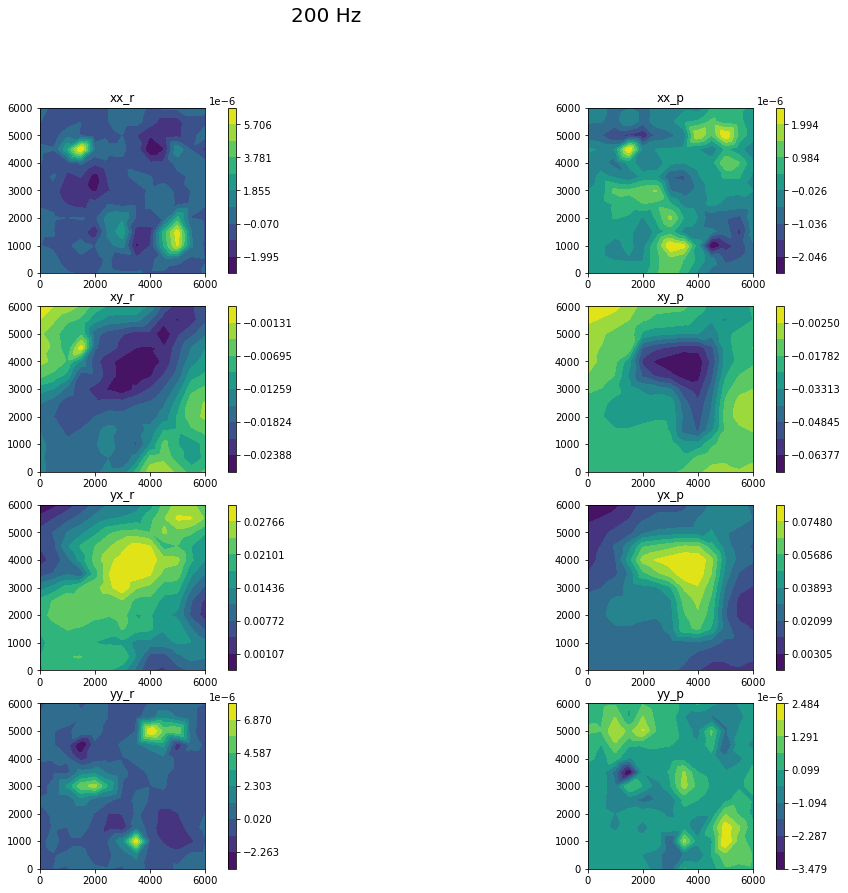

In [50]:
# plotting residual maps
freqs = ['10', '50', '200']
comps_ = ['xx_r', 'xx_p', 'xy_r', 'xy_p', 'yx_r', 'yx_p', 'yy_r', 'yy_p']

cnt = 0
for freq in freqs:
    cnt_comp = 0
    fig1 = plt.figure(figsize=(18, 14))
    for rx_orientation in range(len(comps_)):
        ax = plt.subplot(4,2, cnt_comp + 1)
        residual = (dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] -
                    dpred_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]) / Wd_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]
        im = utils.plot_utils.plot2Ddata(rx_loc, residual, ax=ax)
        ax.set_title(comps_[rx_orientation])
        plt.colorbar(im[0])
        cnt_comp += 1
    cnt += 1
    fig1.suptitle(freq + ' Hz', fontsize='20')
plt.show()

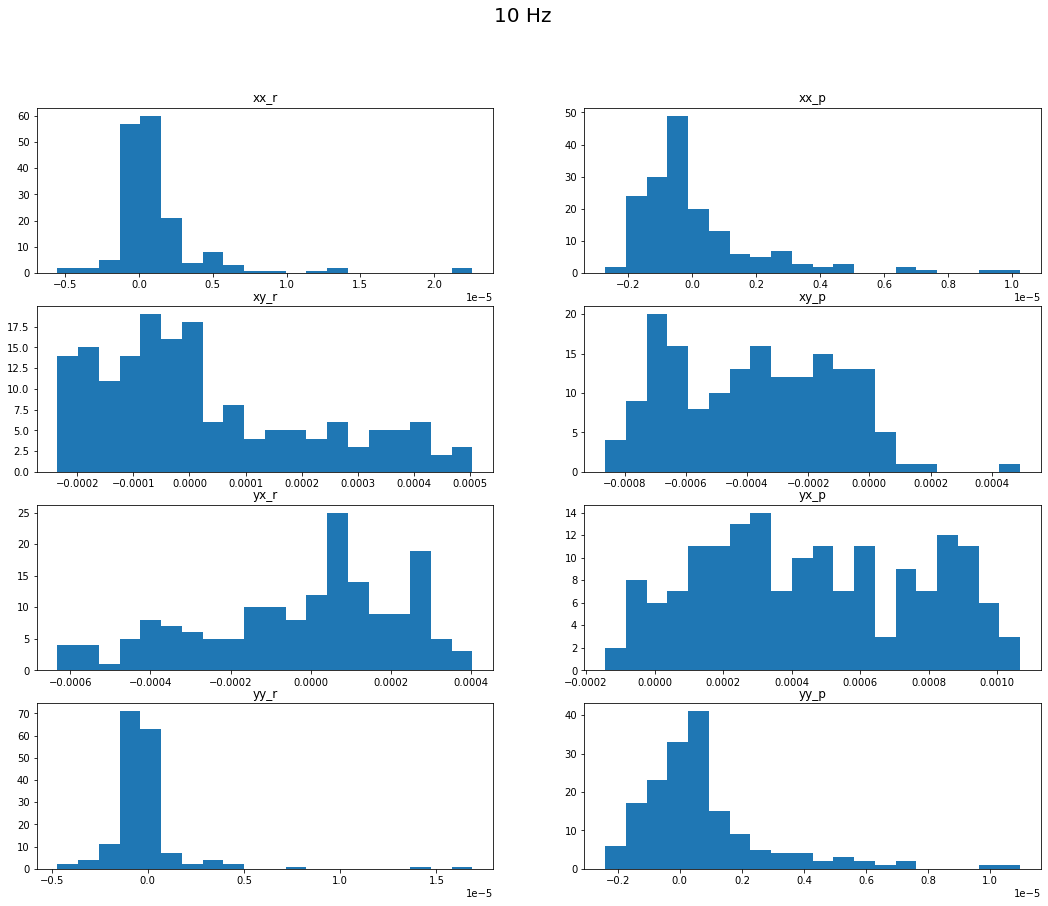

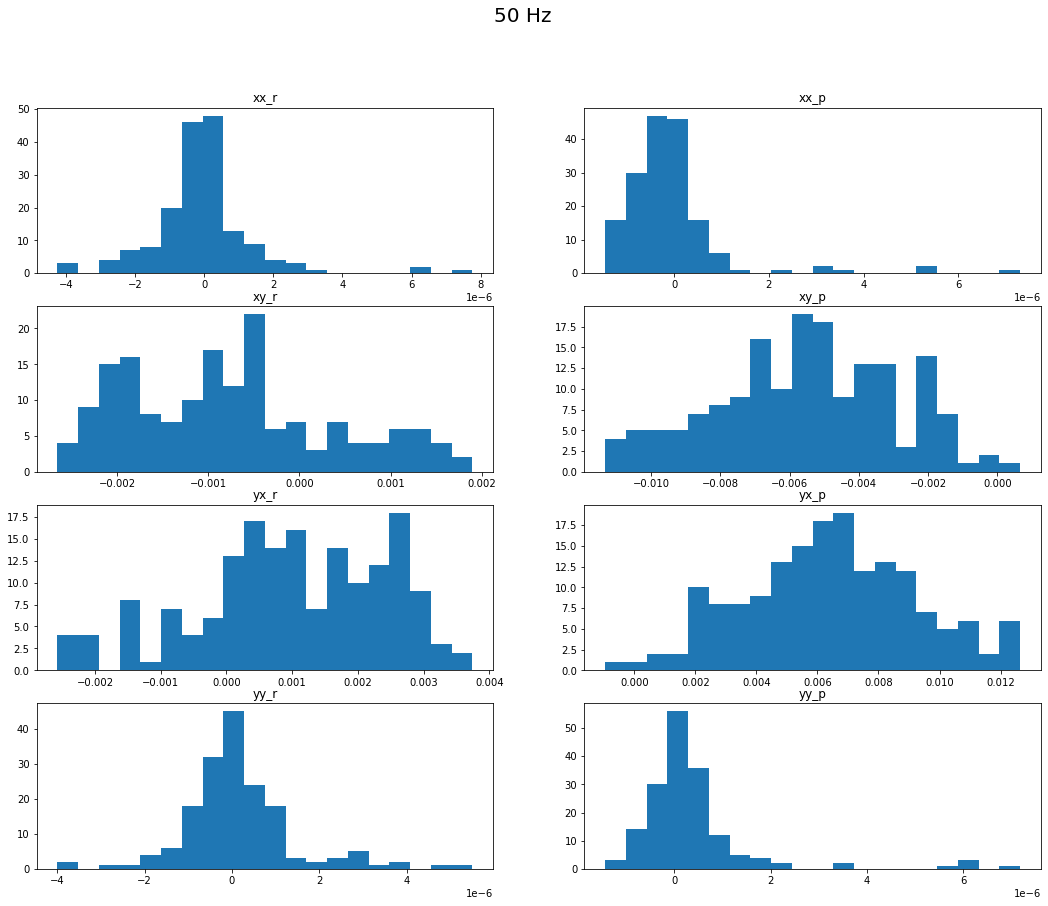

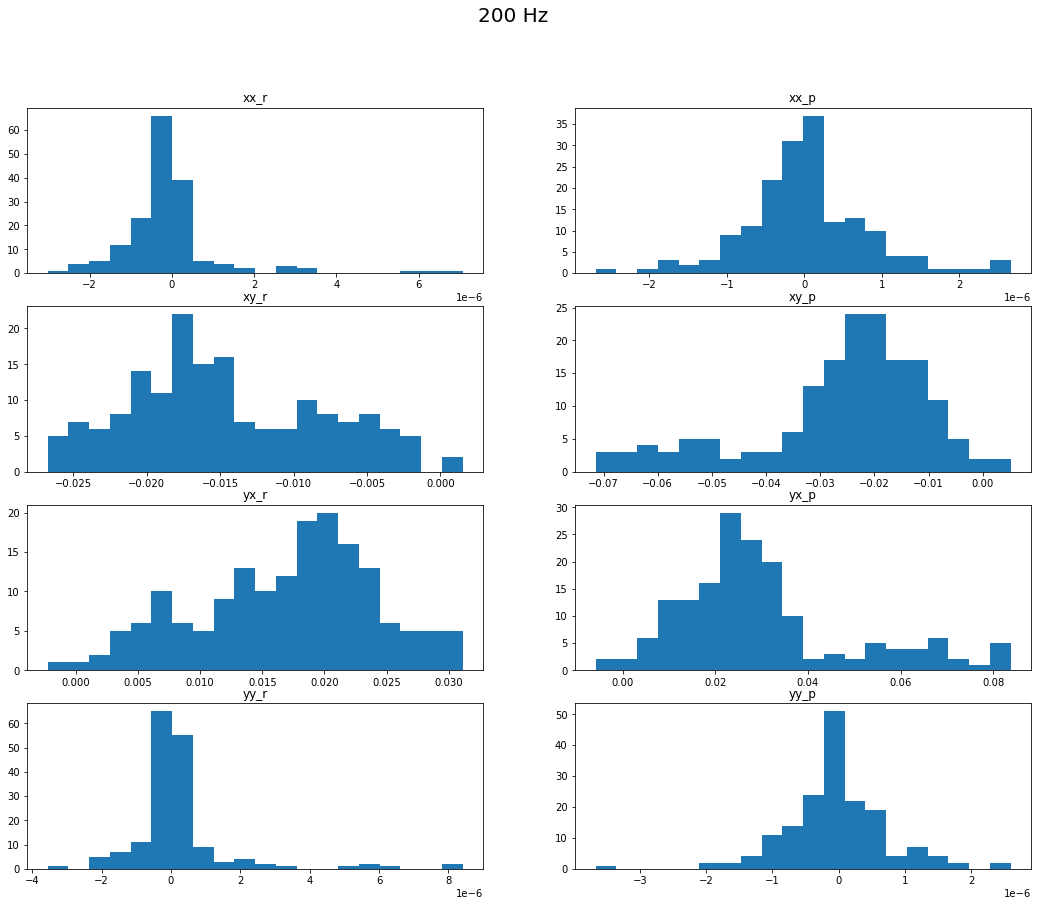

In [51]:
# plotting residual histograms
comps_ = ['xx_r', 'xx_p', 'xy_r', 'xy_p', 'yx_r', 'yx_p', 'yy_r', 'yy_p']
cnt = 0
for freq in freqs:
    cnt_comp = 0
    fig = plt.figure(figsize=(18, 14))
    for rx_orientation in range(len(comps_)):
        ax = plt.subplot(4,2, cnt_comp + 1)
        residual = (dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] -
                    dpred_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]) / Wd_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]
        ax.hist(residual, 20)
        ax.set_title(comps_[rx_orientation])
        cnt_comp += 1
    cnt += 1
    fig.suptitle(freq + ' Hz', fontsize='20')
plt.show()

In [ ]:
np.save('Lb-imp_all-octree-obs-v2.npy', survey.dobs)
np.save('Lb-imp_all-octree-dpred-v2.npy', invProb.dpred)
np.save('Lb-imp_all-octree-dmis-v2.npy', d_wd)
print(5000 / 60)